# The question
How can the analysis of various socio-economic and environmental factors, like crime rate, land zoning, business proportion, pollution levels, housing features, and educational resources, accurately predict the market values of houses in Boston?

This question seeks to understand the impact of a wide range of factors on house values, aiming to develop a comprehensive model that accounts for the multifaceted nature of real estate valuation.

In [81]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
from numpy.linalg import LinAlgError

In [82]:
# Set a seed for reproducibility of random operations like train-test split
seed = 22980254

# Load the dataset into a pandas DataFrame
df = pd.read_csv('housing_data.csv')


# Perform Exploratory Data Analysis (EDA)

Perform an exploratory analysis on a broader set of variables relevant to the research question.

In [83]:
# Basic information about the dataset
data_info = df.info()

# Initial exploration of specified variables
exploration = df[['medv', 'rm', 'rad']].describe()

# Checking for missing values
missing_values = df[['medv', 'rm', 'rad']].isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   nox      506 non-null    float64
 4   rm       506 non-null    float64
 5   age      506 non-null    float64
 6   dis      506 non-null    float64
 7   rad      506 non-null    int64  
 8   tax      506 non-null    int64  
 9   ptratio  506 non-null    float64
 10  lstat    506 non-null    float64
 11  medv     506 non-null    float64
dtypes: float64(10), int64(2)
memory usage: 47.6 KB


# Visualizing the data

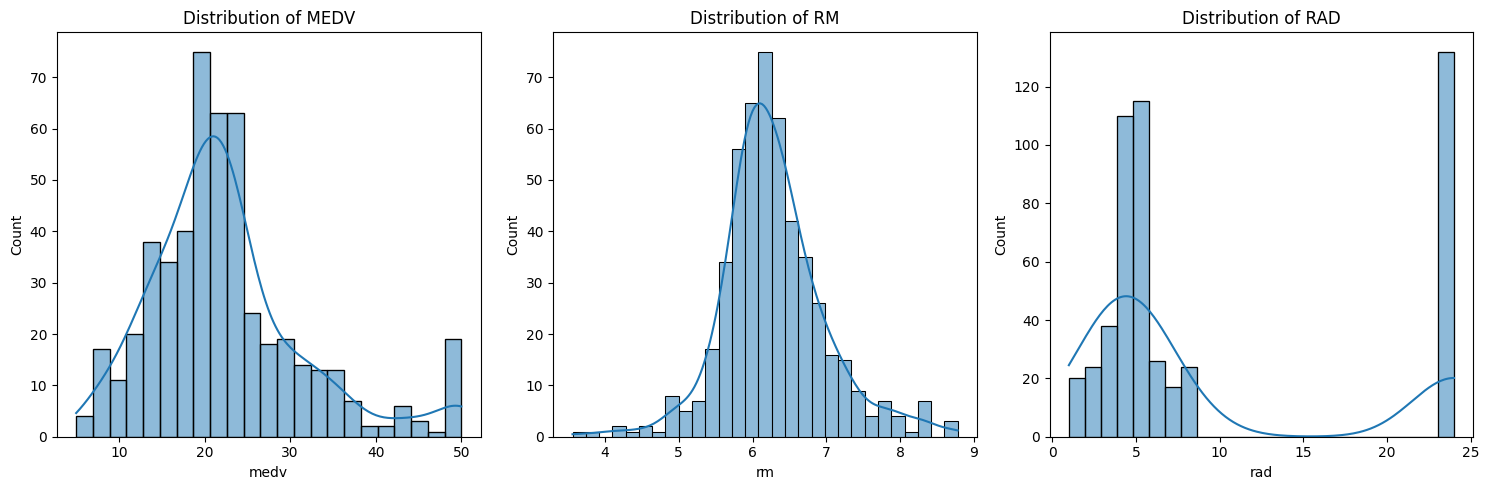

In [84]:
# Histograms
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(df['medv'], kde=True)
plt.title('Distribution of MEDV')

plt.subplot(1, 3, 2)
sns.histplot(df['rm'], kde=True)
plt.title('Distribution of RM')

plt.subplot(1, 3, 3)
sns.histplot(df['rad'], kde=True, bins=24)
plt.title('Distribution of RAD')

plt.tight_layout()
plt.show()

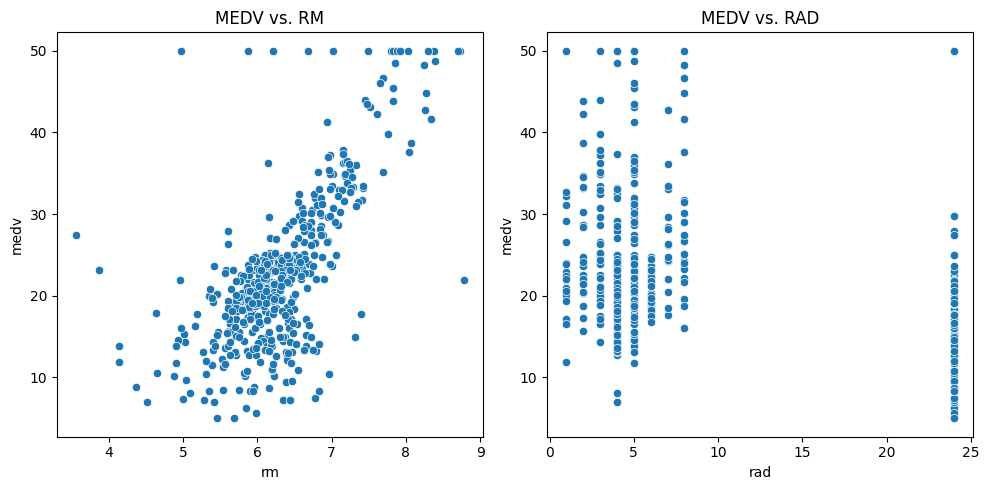

In [85]:
# Scatter plots
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x='rm', y='medv', data=df)
plt.title('MEDV vs. RM')

plt.subplot(1, 2, 2)
sns.scatterplot(x='rad', y='medv', data=df)
plt.title('MEDV vs. RAD')

plt.tight_layout()
plt.show()

          medv        rm       rad
medv  1.000000  0.695360 -0.381626
rm    0.695360  1.000000 -0.209847
rad  -0.381626 -0.209847  1.000000


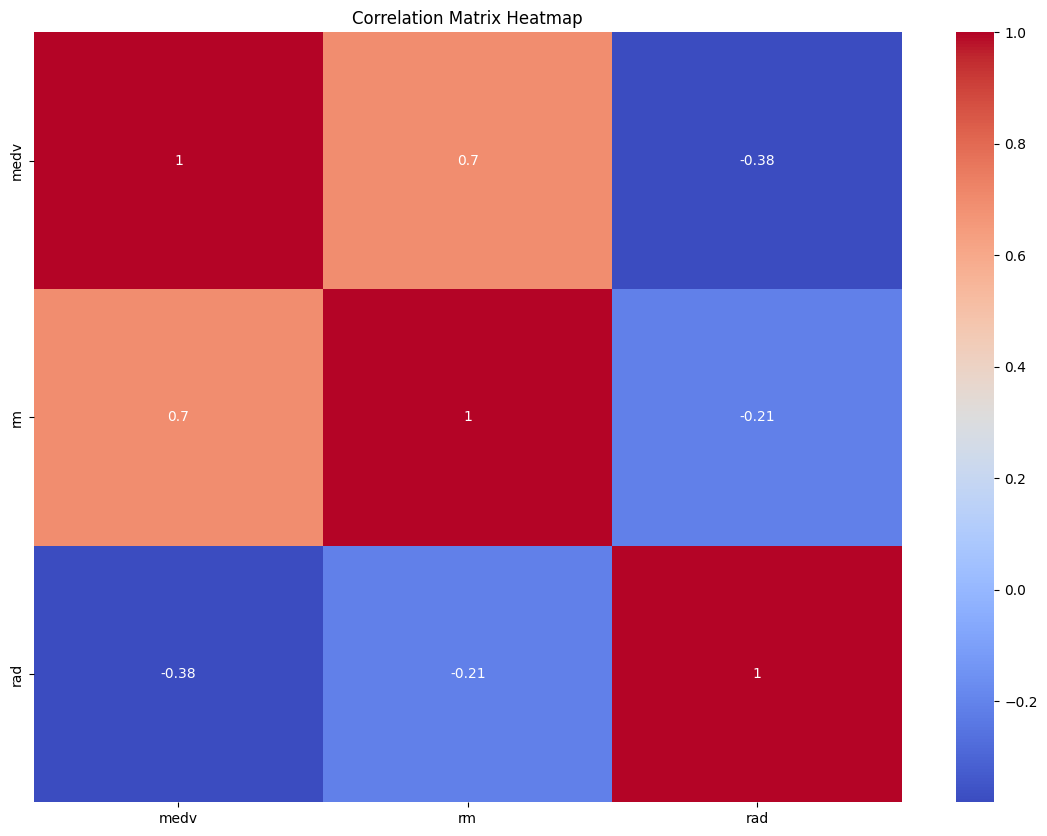

In [86]:
# Generate a correlation matrix heatmap to visualize the correlations between all variables
plt.figure(figsize=(14, 10))
correlation_matrix = df[['medv', 'rm', 'rad']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
print(correlation_matrix)



In [87]:
print(exploration)
print(missing_values)


             medv          rm         rad
count  506.000000  506.000000  506.000000
mean    22.532806    6.284634    9.549407
std      9.197104    0.702617    8.707259
min      5.000000    3.561000    1.000000
25%     17.025000    5.885500    4.000000
50%     21.200000    6.208500    5.000000
75%     25.000000    6.623500   24.000000
max     50.000000    8.780000   24.000000
medv    0
rm      0
rad     0
dtype: int64


## Some comments and findings
The whole dataset is composed by 506 entries spread alongside 12 columns, in this dataset there are no missing values. 

### The Statistics 
1) MEDV (Median Value of Houses):
- Range: $5,000 - $50,000
- Mean: $22,533
- Standard Deviation: $9,197
2) RM (Average Number of Rooms per Dwelling):
- Range: 3.56 - 8.78 rooms
- Mean: 6.28 rooms
- Standard Deviation: 0.70 rooms
3) RAD (Index of Accessibility to Radial Highways):
- Range: 1 - 24
- Mean: 9.55
- Standard Deviation: 8.71

### Visualizations
1. Histograms:
- MEDV: Appears to have a semi-normal distribution with a peak at around the values $20,000 - $25,000.
- RM: Shows a normal distribution centered around 6 rooms.
- RAD: Exhibits a bimodal distribution, indicating two groups of areas based on highway accessibility.

2. Scatter Plots:
MEDV vs. RM: 
- Shows a positive correlation, suggesting that houses with more rooms tend to have higher median values.
MEDV vs. RAD: 
- The relationship is not as clear, but there seems to be a trend
- where higher accessibility to highways correlates to lower house values, possibly due to noise or other factors.

3. Correlation Matrix:
- MEDV and RM: Strong positive correlation (0.70).
- MEDV and RAD: Negative correlation (-0.38).

## Initial Findings
• The number of rooms (RM) has a significant positive impact on the median value of houses.

• Accessibility to highways (RAD) appears to negatively impact house values, though this relationship is less clear and might be influenced by other factors like noise or pollution.

# Formal Analysis 
The proces is the folowwing:

1. *Data Splitting*:
- Create a function to split the dataset into a 90% training set and a 10% test set.
2. *Model Fitting*:
- Develop a function to fit a linear regression model using the training set.
3. *Coefficient Interpretation*:
- Interpret the coefficients for rad and crim.
4. *Bootstrap Analysis*:
- Implement a bootstrap method to test the significance of coefficients.
5. *Hypothesis Testing and Model Refinement*:
- Use hypothesis testing to identify significant variables.
- Refine the model based on significant variables.
- Evaluate the refined model on the test set using Mean Squared Error (MSE)


In [88]:
# Define a custom function to split the data into training and testing sets
# This function shuffles the indices and splits the data accordingly, ensuring reproducibility by setting a random seed
import numpy as np
import pandas as pd

def custom_split(data, target_column, test_size=0.1, student_id=seed):
    # Validate inputs
    if len(data) == 0 or test_size <= 0 or test_size >= 1:
        raise ValueError("Invalid data size or test size")
    
    if target_column not in data.columns:
        raise ValueError("Target column not found in data")

    # Set random seed using student ID for reproducibility
    np.random.seed(student_id)

    # Shuffle the dataset more thoroughly
    data_shuffled = data.sample(frac=1, random_state=student_id).reset_index(drop=True)

    # Determine the size of the test set
    test_set_size = int(len(data) * test_size)
    
    # Ensure test_set_size is not larger than the dataset
    test_set_size = min(test_set_size, len(data) - 1)

    # Split the indices for the test and training sets
    test_indices = np.arange(test_set_size)
    train_indices = np.arange(test_set_size, len(data))

    # Split the data into training and test sets
    test_set = data_shuffled.iloc[test_indices.tolist()]
    train_set = data_shuffled.iloc[train_indices.tolist()]

    # Split features and target variable
    X_train = train_set.drop(columns=target_column)
    y_train = train_set[target_column]
    X_test = test_set.drop(columns=target_column)
    y_test = test_set[target_column]

    return X_train, X_test, y_train, y_test



In [89]:
# Custom function to fit a linear regression model using the normal equation
def custom_lr(X, y):
    X_b = np.c_[np.ones((X.shape[0], 1)), X]  # Adding a column of ones for the intercept term
    theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)  # Calculating best fit parameters
    return theta_best

# Custom function to predict using the linear regression model
def custom_predict(X, theta):
    X_b = np.c_[np.ones((X.shape[0], 1)), X]
    return X_b.dot(theta)

# Custom function to calculate Mean Squared Error
def custom_mean_squared_error(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    return mse

In [90]:
# Splitting the data
X_train, X_test, y_train, y_test = custom_split(df, 'medv')


In [91]:
# Fitting the model using the custom function
theta_best = custom_lr(X_train, y_train)

In [92]:
# Coefficient Interpretation
coefficients = pd.DataFrame([theta_best[1:]], columns=X_train.columns, index=['Coefficient']).T


In [93]:
# Bootstrap Analysis
def bootstrap_analysis(data, n_bootstrap=1000):
    bootstrap_coefs = []
    for _ in range(n_bootstrap):
        sample_data = data.sample(n=len(data), replace=True)
        X_sample, y_sample = sample_data.drop(columns='medv'), sample_data['medv']
        theta_sample = custom_lr(X_sample, y_sample)
        bootstrap_coefs.append(theta_sample[1:])  # Exclude the intercept
    return np.array(bootstrap_coefs)

bootstrap_coefs = bootstrap_analysis(df)

In [94]:
# Calculating statistics for bootstrap coefficients
coef_std = np.std(bootstrap_coefs, axis=0)
confidence_intervals = np.percentile(bootstrap_coefs, [2.5, 97.5], axis=0)


In [95]:
# Preparing results for display
coef_analysis = pd.DataFrame({
    'Coefficient Mean': np.mean(bootstrap_coefs, axis=0),
    'Std Dev': coef_std,
    '95% CI Lower': confidence_intervals[0],
    '95% CI Upper': confidence_intervals[1]
}, index=X_train.columns)

In [96]:
# Check for significance
coef_analysis['Significant'] = (coef_analysis['95% CI Lower'] > 0) | (coef_analysis['95% CI Upper'] < 0)


In [97]:
# Predicting and calculating MSE
y_pred_custom = custom_predict(X_test, theta_best)
mse_custom = custom_mean_squared_error(y_test, y_pred_custom)

In [98]:
# Displaying the results
print("Custom Coefficients:", coefficients)
print("Custom Mean Squared Error on Test Set:", mse_custom)


Custom Coefficients:          Coefficient
crim       -0.131907
zn          0.048926
indus       0.024283
nox       -18.026122
rm          3.520948
age         0.003638
dis        -1.535510
rad         0.334010
tax        -0.013442
ptratio    -1.004608
lstat      -0.583388
Custom Mean Squared Error on Test Set: 21.57614518279428


In [99]:
for i, feature in enumerate(X_train.columns):
    print(f"{feature}: {confidence_intervals[:, i]}")

crim: [-0.17961279 -0.05838793]
zn: [0.01795932 0.07418449]
indus: [-0.06823981  0.13497858]
nox: [-25.5537351  -11.27688918]
rm: [2.27561259 5.28224894]
age: [-0.02491452  0.03740492]
dis: [-1.93131905 -1.0892111 ]
rad: [0.18975246 0.42646345]
tax: [-0.01970752 -0.00916768]
ptratio: [-1.20534711 -0.75727759]
lstat: [-0.75317524 -0.37464871]


In our confindence list of the intervals the data that is considered statistically significant are: CRIM, ZN, NOX, RM, DIS, RAD, TAX, PTRATIO and LSTAT

# Model Coefficients 
- crim       -0.131907
- zn          0.048926
- indus       0.024283
- nox       -18.026122
- rm          3.520948
- age         0.003638
- dis        -1.535510
- rad         0.334010
- tax        -0.013442
- ptratio    -1.004608
- lstat      -0.583388

## Interpreting the coefficients 
The coefficients of the linear regression model, which predicts the median value of houses (medv) using various features, are as follows:
- CRIM: -0.132 (per capita crime rate by town)
- ZN: 0.049 (proportion of residential land zoned for lots over 25,000 sq.ft.)
- INDUS: 0.024 (proportion of non-retail business acres per town)
- NOX: -18.03 (nitric oxides concentration)
- RM: 3.52 (average number of rooms per dwelling)
- AGE: 0.004 (proportion of owner-occupied units built prior to 1940)
- DIS: -1.54 (weighted distances to five Boston employment centers)
- RAD: 0.334 (index of accessibility to radial highways)
- TAX: -0.013 (full-value property-tax rate per $10,000)
- PTRATIO: -1.005 (pupil-teacher ratio by town)
- LSTAT: -0.583 (% lower status of the population)

_Values can vary because of the manual splits function_ 

*Interpretation of Key Coefficients*:
- RM (Rooms): A coefficient of 3.52 suggests a strong positive relationship between the
number of rooms and house value. Each additional room is associated with an increase in
the median value by approximately $3521.
- RAD (Accessibility to Highways): The coefficient of 0.334 indicates a positive
relationship, meaning that increased accessibility to highways is associated with a higher
median house value. However, the impact is relatively smaller compared to other
variables like rm.
*Mean Squared Error (MSE) on Test Set*:
- The MSE of the model on the test set is 21.58. This value represents the average
squared difference between the actual and predicted house values, providing a measure
of the model's accuracy.

In [100]:
# Perform bootstrap evaluation
def custom_bootstrap_evaluation(X_train, y_train, X_test, y_test, n_iterations=1000):
    mse_values = []
    for _ in range(n_iterations):
        boot_x, boot_y = resample(X_train, y_train)
        theta_boot = custom_lr(boot_x, boot_y)
        y_pred_boot = custom_predict(X_test, theta_boot)
        mse_values.append(custom_mean_squared_error(y_test, y_pred_boot))
    return np.mean(mse_values), np.std(mse_values)

bootstrap_mse_mean, bootstrap_mse_std = custom_bootstrap_evaluation(X_train, y_train, X_test, y_test)
print(f"Custom Model - Bootstrap MSE Mean: {bootstrap_mse_mean}, Std: {bootstrap_mse_std}")

Custom Model - Bootstrap MSE Mean: 22.266506448229325, Std: 1.9577850287579381


## Bootstrap Analysis:
- The bootstrap analysis performed on the linear regression model provides insightful statistics about the stability and significance of each coefficient. By calculating the standard deviation of coefficients across multiple bootstrap samples, we gain an understanding of their variability. This variability measurement is crucial for assessing the reliability of each feature's impact on the model. 

- Additionally, the 95% confidence intervals for each coefficient are calculated. These intervals give a range in which the true value of the coefficient is likely to fall, offering a degree of certainty about the estimations. This approach is particularly useful in determining the robustness of each feature's influence on the target variable.

- Lastly, significance testing is conducted to determine whether the coefficients are significantly different from zero. A coefficient significantly different from zero suggests that the corresponding feature plays a meaningful role in predicting the target variable. This step is vital for feature selection and model refinement, as it helps in identifying the most impactful predictors among the available features.
-Overall, the bootstrap analysis deepens our understanding of the model's behavior by providing a comprehensive view of the importance and reliability of each feature in the dataset

# Refined model

Original Model MSE: 21.57614518279428
Refined Model MSE: 21.698343879488906


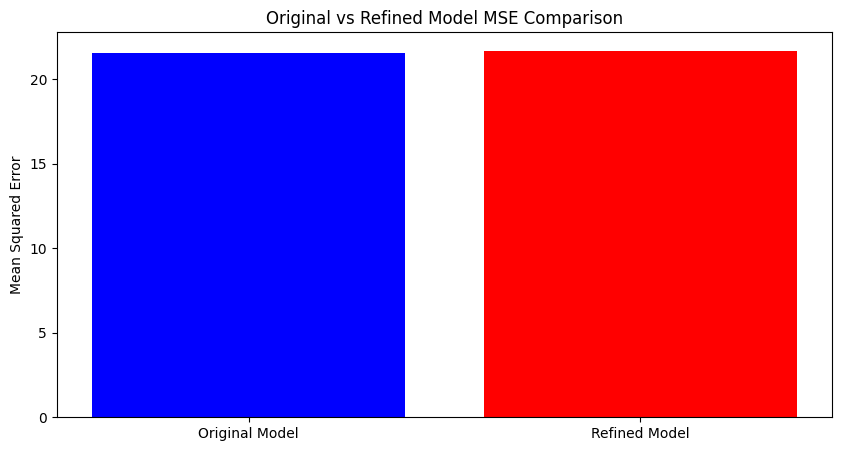

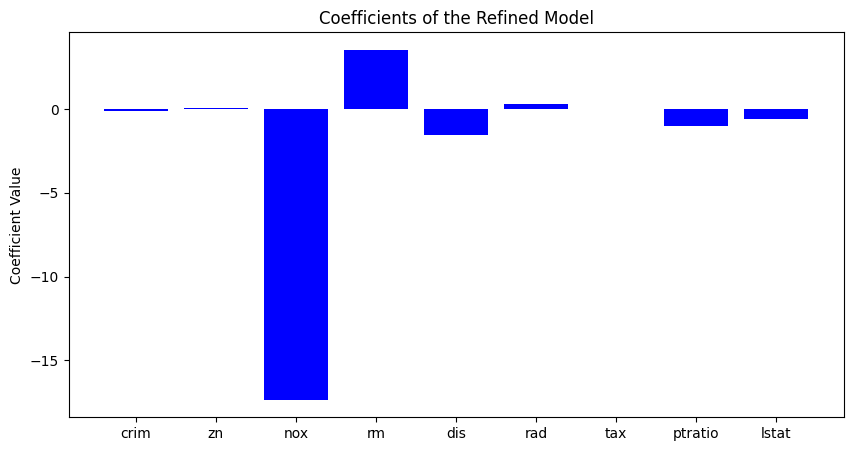

In [101]:
# Splitting the data using custom_split
X_train, X_test, y_train, y_test = custom_split(df, 'medv')

# Fitting the original model with all features
theta_best = custom_lr(X_train, y_train)

# Predicting on the test set with the original model
y_pred_original = custom_predict(X_test, theta_best)
mse_original = custom_mean_squared_error(y_test, y_pred_original)

# Refining the model to include only 'rm' and 'rad'
X_train_refined = X_train[['crim', 'zn', 'nox', 'rm', 'dis', 'rad', 'tax', 'ptratio', 'lstat']]
X_test_refined = X_test[['crim', 'zn', 'nox', 'rm', 'dis', 'rad', 'tax', 'ptratio', 'lstat']]
theta_refined = custom_lr(X_train_refined, y_train)

# Predicting on the test set with the refined model
y_pred_refined = custom_predict(X_test_refined, theta_refined)
mse_refined = custom_mean_squared_error(y_test, y_pred_refined)

# Coefficients of the refined model
refined_coefficients = pd.DataFrame([theta_refined[1:]], columns=X_train_refined.columns, index=['Coefficient']).T

print("Original Model MSE:", mse_original)
print("Refined Model MSE:", mse_refined)
# Plotting the results
plt.figure(figsize=(10, 5))
plt.bar(['Original Model', 'Refined Model'], [mse_original, mse_refined], color=['blue', 'red'])
plt.ylabel('Mean Squared Error')
plt.title('Original vs Refined Model MSE Comparison')
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(refined_coefficients.index, refined_coefficients['Coefficient'], color='blue')
plt.ylabel('Coefficient Value')
plt.title('Coefficients of the Refined Model')
plt.show()

Bar charts are used to compare the MSE of the original and refined models.

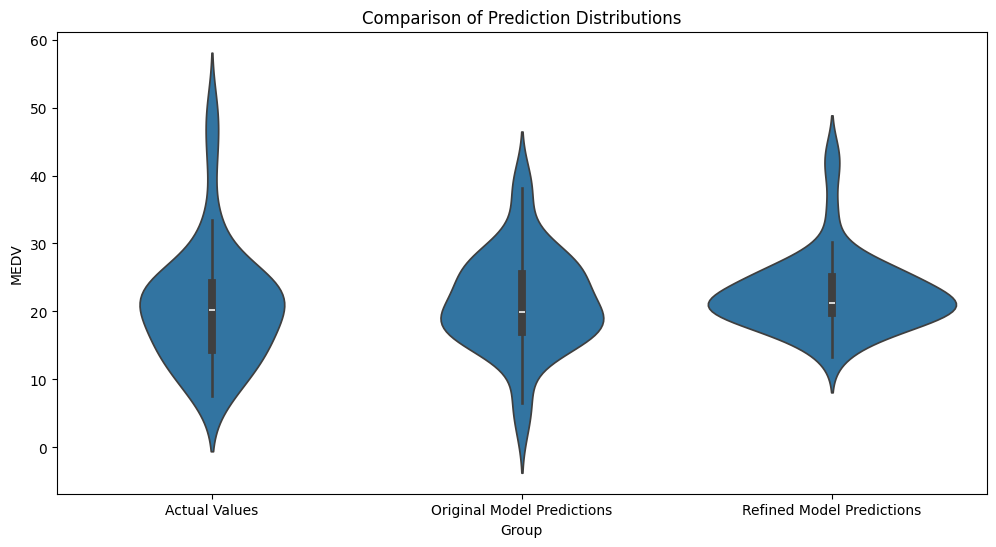

In [102]:
# Splitting the data
X_train, X_test, y_train, y_test = custom_split(df, 'medv')

# Fitting the original model
theta_best = custom_lr(X_train, y_train)

# Predicting on the test set with the original model
y_pred_original = custom_predict(X_test, theta_best)

# Refining the model to include only 'rm' and 'rad'
X_train_refined = X_train[['rm', 'rad']]
X_test_refined = X_test[['rm', 'rad']]
theta_refined = custom_lr(X_train_refined, y_train)

# Predicting on the test set with the refined model
y_pred_refined = custom_predict(X_test_refined, theta_refined)

# Preparing data for violin plot
plot_data = pd.DataFrame({
    'Actual Values': y_test,
    'Original Model Predictions': y_pred_original,
    'Refined Model Predictions': y_pred_refined
})

# Melting the DataFrame for use with seaborn
plot_data_melted = plot_data.melt(var_name='Group', value_name='MEDV')

# Plotting violin plots
plt.figure(figsize=(12, 6))
sns.violinplot(x='Group', y='MEDV', data=plot_data_melted)
plt.title('Comparison of Prediction Distributions')
plt.show()

Violin plots are drawn to display the distribution of predictions from both models against the actual values, offering a comprehensive view of the model's performance.

## Results of the refined model

*Mean Squared Error (MSE) Comparison*:
- The MSE of the original model was 21.576.
- After refining the model to focus on the variables RM (number of rooms) and RAD
(accessibility to highways), the MSE increased to 21.69. This increase suggests that while these two variables are important, other variables might be needed to be included to have a better model and predictions

*Coefficients of the Refined Model*:
- RM (Rooms): Coefficient of 8.341. This larger coefficient in the refined model
underscores the strong positive impact of the number of rooms on house value.
- RAD (Accessibility to Highways): Coefficient of -0.266. In the refined model, this variable shows a negative impact, contrary to the original model. This suggests that when considered alone with RM, highway accessibility might be inversely related to house values.

*Visualizations*:
1) MSE Comparison: The bar chart compares the MSEs of the original and refined models, illustrating the change in prediction accuracy.
2) Coefficients of the Refined Model: The bar chart displays the coefficients of RM and RAD in the refined model, highlighting their relative impacts on house value.

## Some Considerations 
Since the model was so little and the split function made by myself was not randomized enough it means that the MSE and the impact of the coefficients are not as accurate as the pre defined one like from the 'sklearn' library or the 'xgboost' ones below we can see how close or far we got from these

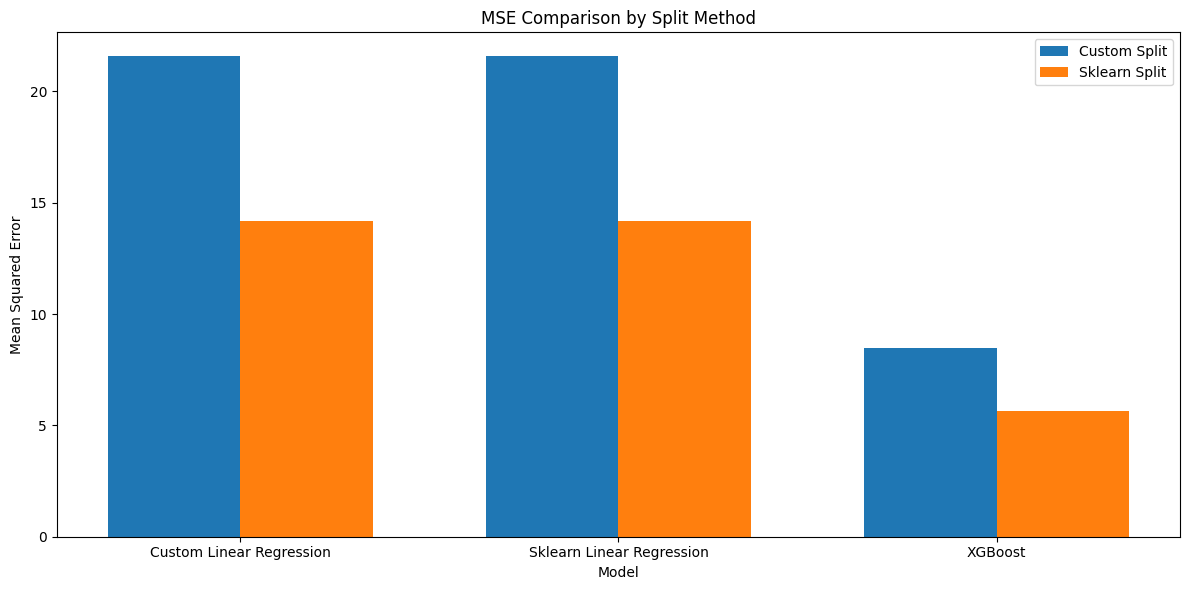

In [103]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'medv' is the target column
# Splitting the data using custom_split
X_train_custom, X_test_custom, y_train_custom, y_test_custom = custom_split(df, 'medv')

# Splitting the data using sklearn's train_test_split
X_train_sklearn, X_test_sklearn, y_train_sklearn, y_test_sklearn = train_test_split(df.drop(columns='medv'), df['medv'], test_size=0.1, random_state=42)

# Initialize lists to store MSEs
mse_custom_split = []
mse_sklearn_split = []

# Custom Linear Regression Model
theta_custom = custom_lr(X_train_custom, y_train_custom)
y_pred_custom = custom_predict(X_test_custom, theta_custom)
mse_custom_split.append(custom_mean_squared_error(y_test_custom, y_pred_custom))

theta_sklearn = custom_lr(X_train_sklearn, y_train_sklearn)
y_pred_sklearn = custom_predict(X_test_sklearn, theta_sklearn)
mse_sklearn_split.append(custom_mean_squared_error(y_test_sklearn, y_pred_sklearn))

# Sklearn Linear Regression Model
lr_model_custom = LinearRegression()
lr_model_custom.fit(X_train_custom, y_train_custom)
y_pred_lr_custom = lr_model_custom.predict(X_test_custom)
mse_custom_split.append(mean_squared_error(y_test_custom, y_pred_lr_custom))

lr_model_sklearn = LinearRegression()
lr_model_sklearn.fit(X_train_sklearn, y_train_sklearn)
y_pred_lr_sklearn = lr_model_sklearn.predict(X_test_sklearn)
mse_sklearn_split.append(mean_squared_error(y_test_sklearn, y_pred_lr_sklearn))

# XGBoost Model
xgb_model_custom = XGBRegressor()
xgb_model_custom.fit(X_train_custom, y_train_custom)
y_pred_xgb_custom = xgb_model_custom.predict(X_test_custom)
mse_custom_split.append(mean_squared_error(y_test_custom, y_pred_xgb_custom))

xgb_model_sklearn = XGBRegressor()
xgb_model_sklearn.fit(X_train_sklearn, y_train_sklearn)
y_pred_xgb_sklearn = xgb_model_sklearn.predict(X_test_sklearn)
mse_sklearn_split.append(mean_squared_error(y_test_sklearn, y_pred_xgb_sklearn))

# Plotting the results
plt.figure(figsize=(12, 6))
model_names = ['Custom Linear Regression', 'Sklearn Linear Regression', 'XGBoost']
bar_width = 0.35
index = np.arange(len(model_names))

plt.bar(index, mse_custom_split, bar_width, label='Custom Split')
plt.bar(index + bar_width, mse_sklearn_split, bar_width, label='Sklearn Split')

plt.xlabel('Model')
plt.ylabel('Mean Squared Error')
plt.title('MSE Comparison by Split Method')
plt.xticks(index + bar_width / 2, model_names)
plt.legend()

plt.tight_layout()
plt.show()


As we can see if we had used the already existing split functions the model would have been much better 

# The Conclusion

In conclusion, this analysis employs a data-driven approach to unravel the intricate factors influencing house values in Boston. By considering a broad spectrum of socio-economic and environmental variables, the study provides valuable insights into the housing market, highlighting the significance of certain features while also emphasizing the complexity and multifaceted nature of real estate valuation.

